In [16]:
from tqdm import tqdm

from ADAPTIVE_QAOA.adaptive_qaoa_src.Ansatz import *
import scipy as sc
from qiskit.visualization import plot_histogram

In [23]:
# Generating random graph 
n = 3
rng_seed = int(np.random.randint(0,2**31-1))
np.random.seed(rng_seed)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = generate_random_graph(nodes=n,weighted=True,w_min=1e-2,seed=rng_seed)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)


Best solution = [0 1 0] cost = -0.9845


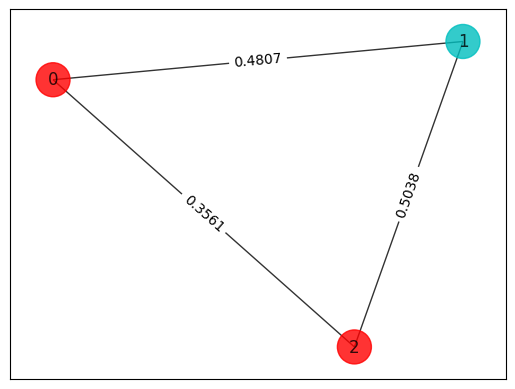

In [24]:
# Calculating optimal partition and plotting
best_cost, best_perm = qubo_min_cost_partition(nr_nodes=n,Q_mat=get_qubo(size=n,edges=edge_list))
colors = ["r" if best_perm[i] == 0 else "c" for i in range(n)]
print("\nBest solution = " + str(best_perm) + " cost = " + str(best_cost))
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [25]:
# Defining instance of QAOA ansatz
QAOA_objective = ADAPTIVEQAOAansatz(n_qubits=n,w_edges=edge_list, precision=64)

# Number of repetitions of (cost, mixer) in circuit
layers=3

# Initial guess for parameters (beta, gamma) of circuit
np.random.seed(0)
theta_min, theta_max = -np.pi, np.pi
#theta_i = np.random.uniform(low=theta_min, high=theta_max, size=2*layers)

gamma_i = (0.01*np.ones(layers)).tolist()
#gamma_i = np.random.uniform(low=theta_min, high=theta_max, size=layers).tolist()
beta_i  = np.random.uniform(low=theta_min, high=theta_max, size=layers).tolist()

theta_i = gamma_i+beta_i

# Function to track optimization progress using tqdm
def callback(xk,*_):
    pbar.update(1)

# ------ Optimizer run ------ #

# Optimizer technique 1)
_available_methods_ = ['Nelder-Mead', 'Powell', 'COBYLA', 'trust-constr']
with tqdm(total=None, desc="Optimizing", ascii=True) as pbar:
    res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[0],callback=callback, options={'disp': True, 'maxiter': 400})

# Optimizer technique 2)
#res = sc.optimize.basinhopping(func=QAOA_objective.evaluate_circuit, x0=theta_i, niter=10, stepsize=0.75,callback=printx)

# Optimizer technique 3)
#_available_strategies_ = ['best1bin', 'best1exp', 'rand1exp', 'randtobest1exp', 'currenttobest1exp', 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']
#res = sc.optimize.differential_evolution(func=QAOA_objective.evaluate_circuit,bounds=[(theta_min, theta_max) for angle in theta_i], strategy=_available_strategies_[1],popsize=2, maxiter=50,callback=printx)

# Optimizer technique 4)
#_available_sampling_methods_ = ['simplicial', 'halton', 'sobol']
#res = sc.optimize.shgo(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], sampling_method=_available_sampling_methods_[2],callback=printx)

# Optimizer technique 5)
#res = sc.optimize.dual_annealing(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=1000)

# Optimizer technique 6)
#res = sc.optimize.direct(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=400)

# Final parameters (beta, gamma) for circuit
theta_f = res.x.tolist()
res

Optimizing: 399it [04:09,  1.48it/s]/var/folders/lf/g00xwz855rs9xhsrn28h139c0000gn/T/ipykernel_2749/1458972875.py:27: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[0],callback=callback, options={'disp': True, 'maxiter': 400})
Optimizing: 399it [04:09,  1.60it/s]


 final_simplex: (array([[0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269],
       [0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269],
       [0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269],
       [0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269],
       [0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269],
       [0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269],
       [0.01016667, 0.01016667, 0.0095    , 0.31181603, 1.37460924,
        0.65644269]]), array([-0.94686068, -0.78528297, -0.59889087, -0.56150039, -0.55444361,
       -0.5520091 , -0.40617148]))
           fun: -0.9468606819733784
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 1086
           nit: 400
        status: 2
       success: False
             x: array([0.01016667, 0.01016667, 0.0095    , 0.3118160

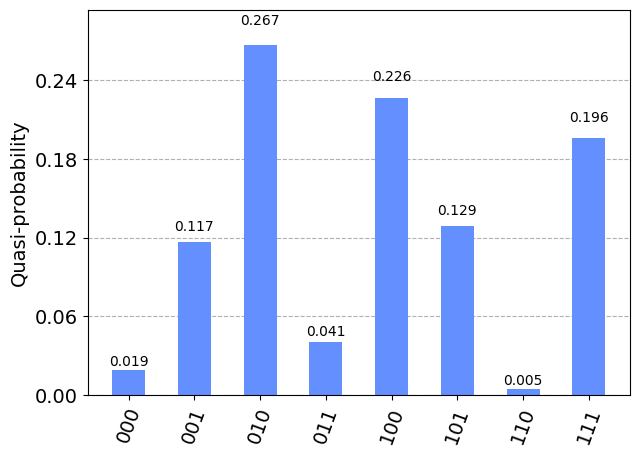

In [26]:
QAOA_objective.set_circuit(theta=theta_f)
plot_histogram(QAOA_objective.current_circuit.get_state_probabilities(reverse_states=True))